In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

digits_data = datasets.load_digits()
input_data = digits_data.data
correct = digits_data.target
n_data = len(correct)


In [152]:
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

In [153]:
correct_data = np.zeros((n_data,10))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [154]:
index = np.arange(n_data)
index_train = index[index % 3 != 0]
index_test = index[index % 3 == 0]

In [155]:
input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

In [156]:
n_train = input_train.shape[0]
n_test = input_test.shape[0]

In [157]:
img_h = 8
img_w = 8
img_ch = 1

wb_width = 0.1
eta = 0.01
epoch = 50
batch_size = 8
interval = 10
n_sample = 200

In [158]:
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):

    n_bt, n_ch, img_h, img_w = images.shape

    img_pad = np.pad(images, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(
        n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [159]:
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):

    n_bt, n_ch, img_h, img_w = img_shape

    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3, 0, 1, 2, 4, 5)

    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [160]:
class ConvLayer:
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)

        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)

        self.y_ch = n_flt
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1

        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8

    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)

        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0,0,self.u)

    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)

        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)

        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)

    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w

        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [161]:
class PoolingLayer:

    def __init__(self, x_ch, x_h, x_w, pool, pad):
        self.params = (x_ch, x_h, x_w, pool, pad)

        self.y_ch = x_ch
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1

    def forward(self, x):
        n_bt = x.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)

        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)

        self.max_index = np.argmax(cols, axis=1)

    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w

        grad_y = grad_y.transpose(0, 2, 3, 1)

        grad_cols = np.zeros((pool*pool, grad_y.size))

        grad_cols[self.max_index.reshape(-1), 
                  np.arange(grad_y.size)] = grad_y.reshape(-1)
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5, 0, 1, 2, 3, 4)
        grad_cols = grad_cols.reshape(y_ch*pool*pool, n_bt*y_h*y_w)

        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [162]:
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8

    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w

        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [163]:
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)

    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)

In [164]:
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)

    def backward(self, t):
        delta = self.y - t

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)

In [165]:
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w
ml_1 = MiddleLayer(n_fc_in, 100)
ol_1 = OutputLayer(100, 10)

In [166]:
def forward_propagation(x):
    n_bt = x.shape[0]

    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)

    fc_input = pl_1.y.reshape(n_bt, -1)
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)

In [167]:
def backpropagation(t):
    n_bt = t.shape[0]

    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)

    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)

In [168]:
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)

In [169]:
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size

In [170]:
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand)
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

In [171]:
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [172]:
n_batch = n_train // batch_size
for i in range(epoch):
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)

    x, t = forward_sample(input_test, correct_test, n_sample)
    error_test = get_error(t, n_sample)

    train_error_x.append(i)
    train_error_y.append(error_train)
    test_error_x.append(i)
    test_error_y.append(error_test)

    if i%interval == 0:
        print("Epoch: " + str(i) + "/" + str(epoch),
              "Error_train: " + str(error_train),
              "Error_test: " + str(error_test))
        
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)
    for j in range(n_batch):

        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)
        uppdate_wb()

Epoch: 0/50 Error_train: 2.3647441509259277 Error_test: 2.404697397664879


Epoch: 10/50 Error_train: 0.05324604308735042 Error_test: 0.08228392608365959
Epoch: 20/50 Error_train: 0.02923188588811426 Error_test: 0.10325146469423188
Epoch: 30/50 Error_train: 0.01823848411888908 Error_test: 0.0732949764037659
Epoch: 40/50 Error_train: 0.01596786551885663 Error_test: 0.06177767452810118


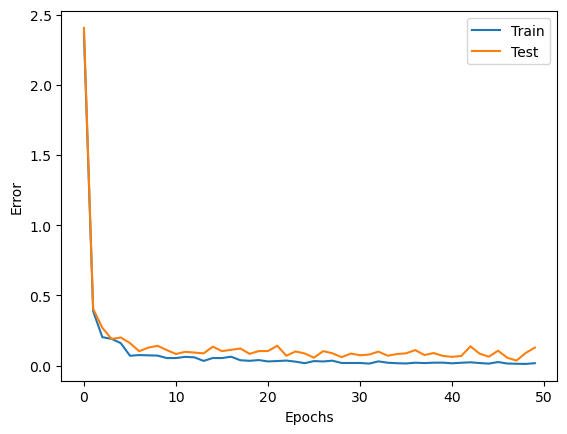

In [173]:
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [178]:
x, t = forward_sample(input_train, correct_train, n_train)
count_train = np.sum(np.argmax(ol_1.y, axis=1)) == np.argmax(t, axis=1)
x, t = forward_sample(input_test, correct_test, n_test)
count_test = np.sum(np.argmax(ol_1.y, axis=1)) == np.argmax(t, axis=1)

print("Accuracy Train: ", str(count_train/n_train*100) + "%"
      "Accuracy Test: ", str(count_test/n_test*100) + "%")

Accuracy Train:  [0. 0. 0. ... 0. 0. 0.]%Accuracy Test:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [175]:
samples = input_test[:5]
forward_propagation(samples)
print(ol_1.y)
print(correct_test[:5])

[[9.99994666e-01 2.16949877e-11 2.43774062e-08 1.42072043e-10
  7.10702058e-09 3.84956325e-06 4.90926528e-10 1.41411931e-07
  4.85269596e-07 8.25960105e-07]
 [6.38067517e-11 8.69502715e-08 4.01134212e-07 9.99835036e-01
  3.48796863e-11 4.48944241e-05 6.32467091e-10 2.38676058e-08
  3.71006250e-06 1.15846457e-04]
 [6.35833258e-07 9.36546775e-05 1.79275035e-07 7.50363284e-08
  1.08876465e-05 3.75622990e-07 9.99774956e-01 1.30591792e-10
  1.19235561e-04 7.64419498e-11]
 [3.77456427e-04 5.61705412e-06 2.49554334e-09 1.22872580e-04
  4.67905957e-06 2.71808994e-01 1.93509142e-08 2.68814854e-06
  2.92428382e-03 7.24753387e-01]
 [1.06053045e-06 2.24192552e-03 9.97718740e-01 1.58831526e-05
  3.54409025e-06 1.61305348e-05 5.74999530e-07 2.99292251e-07
  1.75625908e-06 8.56657783e-08]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
